In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats

%matplotlib inline
from matplotlib import font_manager, rc

font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from pathlib import Path

def load_xml_glucose(path: str) -> pd.DataFrame:
    root = ET.parse(path).getroot()
    pid = str(root.attrib.get("id", Path(path).stem.split("-")[0]))
    rows = []
    for ev in root.find("glucose_level").findall("event"):
        ts = ev.attrib["ts"]
        try:
            ds = pd.to_datetime(ts, format="%d-%m-%Y %H:%M:%S", errors="raise")
        except Exception:
            ds = pd.to_datetime(ts, errors="coerce")  # 형식 다르면 자동 파싱
        rows.append({"patient_id": pid, "ds": ds, "y": float(ev.attrib["value"])})
    df = (pd.DataFrame(rows)
            .dropna(subset=["ds"])
            .sort_values("ds")
            .reset_index(drop=True))
    df["y"] = df["y"].astype("float32")
    return df


In [3]:
dis_train = load_xml_glucose("570-ws-training.xml")
dis_train["group"] = "유병자"

norm = load_xml_glucose("normal_glucose.xml")
norm["group"] = "정상"

len(dis_train), len(norm), dis_train.head(2), norm.head(2)


(10982,
 17280,
   patient_id                  ds      y group
 0        570 2021-12-07 16:29:00  101.0   유병자
 1        570 2021-12-07 16:34:00  100.0   유병자,
   patient_id                  ds     y group
 0        001 2021-12-01 00:00:00  90.0    정상
 1        001 2021-12-01 00:05:00  85.0    정상)

In [4]:
df = pd.concat([norm, dis_train], ignore_index=True)
df["group"] = df["group"].astype("category")
df["patient_id"] = df["patient_id"].astype("category")
print(df["group"].value_counts(), "\n기간:", df["ds"].min(), "~", df["ds"].max())


정상     17280
유병자    10982
Name: group, dtype: int64 
기간: 2021-12-01 00:00:00 ~ 2022-01-29 23:55:00


In [5]:
points_per_day = 24*60//5  # 288
df.groupby("group").size() / points_per_day  # 일수로 환산

group
유병자    38.131944
정상     60.000000
dtype: float64

In [6]:
# 유병자 기간(span) 계산
span = dis_train["ds"].max() - dis_train["ds"].min()

# 정상에서 같은 기간만 추출(마지막 span만큼)
norm_eq = norm[norm["ds"] >= (norm["ds"].max() - span)].copy()
dis_eq  = dis_train.copy()

len(norm_eq), len(dis_eq), norm_eq["ds"].min(), norm_eq["ds"].max()

(11611,
 10982,
 Timestamp('2021-12-20 16:25:00'),
 Timestamp('2022-01-29 23:55:00'))

In [7]:
N = min(len(norm_eq), len(dis_eq))
norm_eq = norm_eq.tail(N).copy()
dis_eq  = dis_eq.tail(N).copy()

len(norm_eq), len(dis_eq)


(10982, 10982)

In [8]:
import numpy as np
import pandas as pd

bins = [-np.inf, 70, 125, 180, np.inf]
labels = ["저혈당(<70)","정상(70-125)","경계(125-180)","고혈당(>180)"]

def tir_pct(d):
    return (pd.cut(d["y"], bins=bins, labels=labels)
              .value_counts(normalize=True)
              .reindex(labels).fillna(0)*100)

tir = pd.concat({
    "정상(%)": tir_pct(norm_eq),
    "유병자(%)": tir_pct(dis_eq)
}, axis=1).round(1)
tir


,정상(%),유병자(%)
저혈당(<70),0.0,2.0
정상(70-125),90.9,17.5
경계(125-180),8.7,25.4
고혈당(>180),0.4,55.1


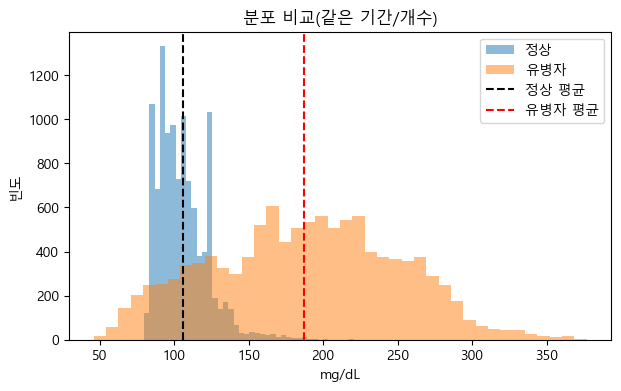

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(norm_eq["y"], bins=40, alpha=0.5, label="정상")
plt.hist(dis_eq["y"],  bins=40, alpha=0.5, label="유병자")
plt.axvline(norm_eq["y"].mean(), color="k", linestyle="--", label="정상 평균")
plt.axvline(dis_eq["y"].mean(),  color="r", linestyle="--", label="유병자 평균")
plt.title("분포 비교(같은 기간/개수)")
plt.xlabel("mg/dL"); plt.ylabel("빈도"); plt.legend(); plt.show()


In [10]:
try:
    _ = norm_eq, dis_eq
except NameError:
    # 유병자 기간과 개수에 맞춰 정상 세트를 자동 생성
    span = dis_train["ds"].max() - dis_train["ds"].min()
    norm_eq = norm[norm["ds"] >= (norm["ds"].max() - span)].copy()
    dis_eq  = dis_train.copy()
    N = min(len(norm_eq), len(dis_eq))
    norm_eq = norm_eq.tail(N).copy()
    dis_eq  = dis_eq.tail(N).copy()

print(len(norm_eq), len(dis_eq), norm_eq["ds"].min(), norm_eq["ds"].max())


10982 10982 2021-12-22 20:50:00 2022-01-29 23:55:00


In [11]:
import pandas as pd

def add_time_feats(d: pd.DataFrame) -> pd.DataFrame:
    d = d.copy()
    d["hour"] = d["ds"].dt.hour
    d["weekday"] = d["ds"].dt.day_name()  # 요일명
    return d

norm_t = add_time_feats(norm_eq); norm_t["group"] = "정상"
dis_t  = add_time_feats(dis_eq);  dis_t["group"]  = "유병자"
df_t   = pd.concat([norm_t, dis_t], ignore_index=True)


In [12]:
hour_mean = df_t.groupby(["group","hour"])["y"].mean().unstack(0).round(1)
hour_mean  # ← 표로 확인


group,유병자,정상
hour,,
0,175.199997,94.599998
1,190.000000,95.300003
2,202.199997,100.300003
3,210.100006,97.099998
4,212.800003,98.500000
5,224.600006,96.699997
6,223.899994,100.199997
7,231.600006,122.699997
8,245.300003,123.000000


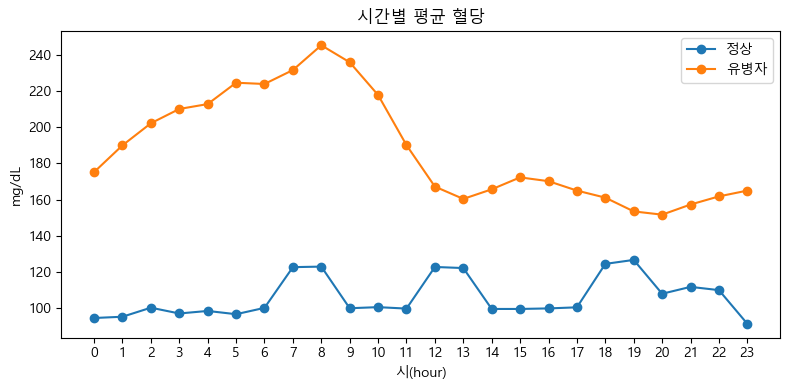

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(hour_mean.index, hour_mean["정상"], marker="o", label="정상")
plt.plot(hour_mean.index, hour_mean["유병자"], marker="o", label="유병자")
plt.title("시간별 평균 혈당")
plt.xlabel("시(hour)"); plt.ylabel("mg/dL"); plt.legend(); plt.xticks(range(0,24)); plt.tight_layout(); plt.show()


In [14]:
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
wk_mean = (df_t.groupby(["group","weekday"])["y"]
             .mean().unstack(0).reindex(weekday_order).round(1))
wk_mean  # ← 표로 확인


group,유병자,정상
weekday,,
Monday,187.800003,102.099998
Tuesday,185.600006,102.000000
Wednesday,200.800003,101.900002
Thursday,190.000000,101.800003
Friday,200.100006,109.300003
Saturday,172.600006,110.900002
Sunday,175.199997,113.800003


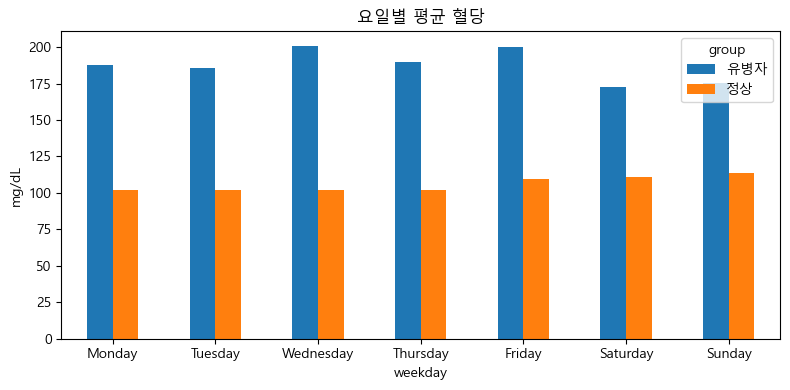

In [15]:
wk_mean.plot(kind="bar", figsize=(8,4))
plt.title("요일별 평균 혈당")
plt.ylabel("mg/dL"); plt.xticks(rotation=0); plt.tight_layout(); plt.show()


In [16]:
import pandas as pd
import numpy as np

# 정상 데이터 선택 (필요시 d = norm_raw.copy() 등으로 변경)
d = norm_eq.copy()

# 일(day) 단위 평균 혈당
daily = (d.set_index("ds")["y"]
           .resample("D").mean()
           .dropna()
           .to_frame("mean_glucose"))

daily["dow"] = daily.index.dayofweek           # Mon=0 ... Sun=6
daily["weekend"] = daily["dow"].isin([4,5,6])  # 금토일 = True
daily.head()


,mean_glucose,dow,weekend
ds,,,
2021-12-22,95.868423,2,False
2021-12-23,101.652779,3,False
2021-12-24,110.354164,4,True
2021-12-25,116.513885,5,True
2021-12-26,109.697914,6,True


In [17]:
from scipy.stats import mannwhitneyu

wd = daily.loc[~daily["weekend"], "mean_glucose"]  # 주중(월~목)
wk = daily.loc[daily["weekend"],  "mean_glucose"]  # 주말(금~일)

U, p = mannwhitneyu(wk, wd, alternative="two-sided")

def cohens_d(a, b):
    na, nb = len(a), len(b)
    sp = np.sqrt(((na-1)*np.var(a, ddof=1) + (nb-1)*np.var(b, ddof=1)) / (na+nb-2))
    return (np.mean(a) - np.mean(b)) / sp

print(f"[정상] 표본수: 주중={len(wd)}, 주말={len(wk)}")
print(f"[정상] 평균: 주중={wd.mean():.1f} mg/dL, 주말={wk.mean():.1f} mg/dL")
print(f"[정상] Mann–Whitney U p-value = {p:.4f}")
print(f"[정상] Cohen's d (주말-주중) = {cohens_d(wk, wd):.2f}")


[정상] 표본수: 주중=22, 주말=17
[정상] 평균: 주중=101.7 mg/dL, 주말=111.2 mg/dL
[정상] Mann–Whitney U p-value = 0.0000
[정상] Cohen's d (주말-주중) = 3.20


In [18]:
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

# 7요일 간 차이(비모수): Kruskal–Wallis
groups = [daily.loc[daily["dow"]==i, "mean_glucose"].values for i in range(7)]
H, p_kw = kruskal(*groups)
print(f"[정상] Kruskal–Wallis(7요일) p-value = {p_kw:.4f}")

# (금/토/일) 각각을 '주중(월~목)'과 비교 — Holm 보정
weekdays = daily.loc[daily["dow"].isin([0,1,2,3]), "mean_glucose"]
pairs = []
for day,label in [(4,"Fri"),(5,"Sat"),(6,"Sun")]:
    g = daily.loc[daily["dow"]==day, "mean_glucose"]
    U, pv = mannwhitneyu(g, weekdays, alternative="two-sided")
    pairs.append((label, pv, g.mean(), weekdays.mean()))

pvals = [pv for _, pv, _, _ in pairs]
rej, p_adj, _, _ = multipletests(pvals, alpha=0.05, method="holm")

for i,(label,pv,gm,wm) in enumerate(pairs):
    print(f"[정상] {label} vs Weekdays → raw p={pv:.4f}, Holm p={p_adj[i]:.4f}, "
          f"mean_diff={gm-wm:.1f} mg/dL, significant={rej[i]}")


[정상] Kruskal–Wallis(7요일) p-value = 0.0001
[정상] Fri vs Weekdays → raw p=0.0002, Holm p=0.0007, mean_diff=7.6 mg/dL, significant=True
[정상] Sat vs Weekdays → raw p=0.0002, Holm p=0.0007, mean_diff=9.2 mg/dL, significant=True
[정상] Sun vs Weekdays → raw p=0.0007, Holm p=0.0007, mean_diff=12.1 mg/dL, significant=True


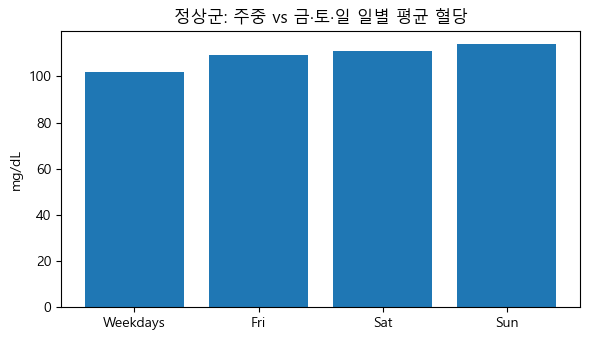

In [19]:
import matplotlib.pyplot as plt

means = {
    "Weekdays": daily.loc[daily["dow"].isin([0,1,2,3]), "mean_glucose"].mean(),
    "Fri":      daily.loc[daily["dow"]==4, "mean_glucose"].mean(),
    "Sat":      daily.loc[daily["dow"]==5, "mean_glucose"].mean(),
    "Sun":      daily.loc[daily["dow"]==6, "mean_glucose"].mean(),
}
plt.figure(figsize=(6,3.5))
plt.bar(list(means.keys()), list(means.values()))
plt.title("정상군: 주중 vs 금·토·일 일별 평균 혈당")
plt.ylabel("mg/dL"); plt.tight_layout(); plt.show()


In [20]:
import pandas as pd
import numpy as np

# 유병자 데이터 선택: 있으면 dis_eq(기간/개수 맞춘 세트), 없으면 dis_train
try:
    d = dis_eq.copy()
except NameError:
    d = dis_train.copy()

daily = (d.set_index("ds")["y"]
           .resample("D").mean()
           .dropna()
           .to_frame("mean_glucose"))

daily["dow"] = daily.index.dayofweek           # Mon=0 ... Sun=6
daily["weekend"] = daily["dow"].isin([4,5,6])  # 금·토·일 = True
daily.head()


,mean_glucose,dow,weekend
ds,,,
2021-12-07,117.329544,1,False
2021-12-08,168.878479,2,False
2021-12-09,202.871521,3,False
2021-12-10,188.937500,4,True
2021-12-11,175.718750,5,True


In [21]:
from scipy.stats import mannwhitneyu

wd = daily.loc[~daily["weekend"], "mean_glucose"]  # 주중(월~목)
wk = daily.loc[daily["weekend"],  "mean_glucose"]  # 주말(금~일)

# 단측: 주중이 주말보다 크다 (wd > wk)
U, p_one = mannwhitneyu(wd, wk, alternative="greater")

# 참고로 양측도 같이 계산
_, p_two = mannwhitneyu(wd, wk, alternative="two-sided")

def cohens_d(a, b):
    na, nb = len(a), len(b)
    sp = np.sqrt(((na-1)*np.var(a, ddof=1) + (nb-1)*np.var(b, ddof=1)) / (na+nb-2))
    return (np.mean(a) - np.mean(b)) / sp

print(f"[유병자] 표본수: 주중={len(wd)}, 주말={len(wk)}")
print(f"[유병자] 평균:   주중={wd.mean():.1f} mg/dL, 주말={wk.mean():.1f} mg/dL")
print(f"[유병자] Mann–Whitney U (단측: 주중>주말) p = {p_one:.4f}")
print(f"[유병자] Mann–Whitney U (양측)              p = {p_two:.4f}")
print(f"[유병자] Cohen's d (주중-주말) = {cohens_d(wd, wk):.2f}")


[유병자] 표본수: 주중=23, 주말=18
[유병자] 평균:   주중=189.3 mg/dL, 주말=182.2 mg/dL
[유병자] Mann–Whitney U (단측: 주중>주말) p = 0.2350
[유병자] Mann–Whitney U (양측)              p = 0.4700
[유병자] Cohen's d (주중-주말) = 0.21


In [22]:
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

# 7요일 전체 차이(비모수)
groups = [daily.loc[daily["dow"]==i, "mean_glucose"].values for i in range(7)]
H, p_kw = kruskal(*groups)
print(f"[유병자] Kruskal–Wallis(7요일) p = {p_kw:.4f}")

# (금/토/일) 각각을 '주중(월~목)'과 비교 — 단측(주중 > 각 요일), Holm 보정
weekdays = daily.loc[daily["dow"].isin([0,1,2,3]), "mean_glucose"]
pairs = []
raw_p = []
for day,label in [(4,"Fri"),(5,"Sat"),(6,"Sun")]:
    g = daily.loc[daily["dow"]==day, "mean_glucose"]
    U, pv = mannwhitneyu(weekdays, g, alternative="greater")  # 주중 > 해당 요일
    pairs.append((label, pv, weekdays.mean(), g.mean()))
    raw_p.append(pv)

rej, p_adj, _, _ = multipletests(raw_p, alpha=0.05, method="holm")

for i,(label,pv,wm,gm) in enumerate(pairs):
    print(f"[유병자] Weekdays > {label}: raw p={pv:.4f}, Holm p={p_adj[i]:.4f}, "
          f"mean_diff={wm-gm:.1f} mg/dL, significant={rej[i]}")


[유병자] Kruskal–Wallis(7요일) p = 0.5177
[유병자] Weekdays > Fri: raw p=0.7272, Holm p=0.7272, mean_diff=-11.8 mg/dL, significant=False
[유병자] Weekdays > Sat: raw p=0.1641, Holm p=0.4535, mean_diff=18.4 mg/dL, significant=False
[유병자] Weekdays > Sun: raw p=0.1512, Holm p=0.4535, mean_diff=14.9 mg/dL, significant=False


In [23]:
import pandas as pd, numpy as np
from scipy.stats import mannwhitneyu

# 데이터 선택
try:
    d = dis_eq.copy()
except NameError:
    d = dis_train.copy()

# 일별 평균
daily = (d.set_index("ds")["y"].resample("D").mean().dropna().to_frame("mean_glucose"))
daily["dow"] = daily.index.dayofweek          # Mon=0..Sun=6
daily["weekend"] = daily["dow"].isin([4,5,6]) # 금토일=True

wd = daily.loc[~daily["weekend"], "mean_glucose"]  # 주중(월~목)
wk = daily.loc[daily["weekend"],  "mean_glucose"]  # 주말(금~일)

# 단측: 주중 > 주말
U, p_one = mannwhitneyu(wd, wk, alternative="greater")
_, p_two = mannwhitneyu(wd, wk, alternative="two-sided")

def cohens_d(a, b):
    na, nb = len(a), len(b)
    sp = np.sqrt(((na-1)*np.var(a, ddof=1) + (nb-1)*np.var(b, ddof=1)) / (na+nb-2))
    return (np.mean(a) - np.mean(b)) / sp

print(f"[유병자] 표본수  주중={len(wd)}, 주말={len(wk)}")
print(f"[유병자] 평균    주중={wd.mean():.1f} mg/dL, 주말={wk.mean():.1f} mg/dL")
print(f"[유병자] 단측 U검정 (주중>주말) p={p_one:.4f}  | 양측 p={p_two:.4f}")
print(f"[유병자] Cohen's d (주중-주말) = {cohens_d(wd, wk):.2f}")


[유병자] 표본수  주중=23, 주말=18
[유병자] 평균    주중=189.3 mg/dL, 주말=182.2 mg/dL
[유병자] 단측 U검정 (주중>주말) p=0.2350  | 양측 p=0.4700
[유병자] Cohen's d (주중-주말) = 0.21


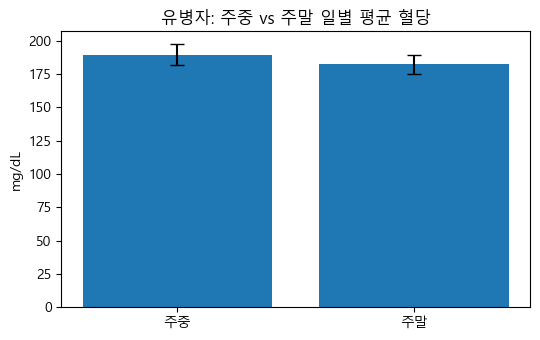

In [24]:
import matplotlib.pyplot as plt
import numpy as np

means = [wd.mean(), wk.mean()]
sems  = [wd.std(ddof=1)/np.sqrt(len(wd)), wk.std(ddof=1)/np.sqrt(len(wk))]

plt.figure(figsize=(5.5,3.5))
plt.bar(["주중","주말"], means, yerr=sems, capsize=5)
plt.title("유병자: 주중 vs 주말 일별 평균 혈당")
plt.ylabel("mg/dL")
plt.tight_layout(); plt.show()


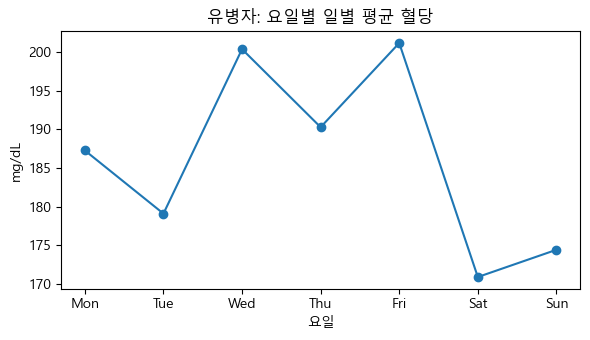

In [25]:
wk_order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
daily["dow_name"] = daily.index.day_name().str[:3]
m = (daily.groupby("dow_name")["mean_glucose"].mean()
         .reindex(wk_order))

plt.figure(figsize=(6,3.5))
plt.plot(m.index, m.values, marker="o")
plt.title("유병자: 요일별 일별 평균 혈당")
plt.ylabel("mg/dL"); plt.xlabel("요일")
plt.tight_layout(); plt.show()


In [26]:
# === 준비/로딩 + 기간/개수 맞춘 세트 생성 (원-클릭) ===
import pandas as pd
import xml.etree.ElementTree as ET
from pathlib import Path

def load_xml_glucose(path: str) -> pd.DataFrame:
    root = ET.parse(path).getroot()
    rows = []
    for ev in root.find("glucose_level").findall("event"):
        ts = ev.attrib["ts"]
        try:
            ds = pd.to_datetime(ts, format="%d-%m-%Y %H:%M:%S", errors="raise")
        except Exception:
            ds = pd.to_datetime(ts, errors="coerce")
        rows.append({"ds": ds, "y": float(ev.attrib["value"])})
    return (pd.DataFrame(rows)
              .dropna(subset=["ds"])
              .sort_values("ds")
              .reset_index(drop=True))

# 1) 유병자 train 로드 (없으면 새로 로드)
if "dis_train" not in globals():
    dis_train = load_xml_glucose("570-ws-training.xml")

# 2) 정상 로드: 주말-스파이크 파일이 있으면 그거, 없으면 원본
if "norm_raw" not in globals():
    normal_path = "normal_patient_glucose_weekend_spikes.xml" if Path("normal_patient_glucose_weekend_spikes.xml").exists() else "normal_patient_glucose.xml"
    norm_raw = load_xml_glucose(normal_path)

# 3) 유병자 기간(span)으로 정상 데이터를 끝 기준 슬라이스
span = dis_train["ds"].max() - dis_train["ds"].min()
norm_eq = norm_raw[norm_raw["ds"] >= (norm_raw["ds"].max() - span)].copy()
dis_eq  = dis_train.copy()

# 4) (선택) 샘플 수까지 동일하게 맞추기 (tail 기준)
N = min(len(norm_eq), len(dis_eq))
norm_eq = norm_eq.tail(N).copy()
dis_eq  = dis_eq.tail(N).copy()

print("norm_eq:", len(norm_eq), norm_eq["ds"].min(), "~", norm_eq["ds"].max())
print("dis_eq :", len(dis_eq),  dis_eq["ds"].min(),  "~", dis_eq["ds"].max())


norm_eq: 10982 2021-12-22 20:50:00 ~ 2022-01-29 23:55:00
dis_eq : 10982 2021-12-07 16:29:00 ~ 2022-01-16 23:59:00


In [27]:
import pandas as pd

def prep_series(df):
    s = (df.set_index("ds")["y"]
           .asfreq("5min")              # 5분 고정 격자
           .ffill())                    # 간헐 결측 보간
    return s

s_norm = prep_series(norm_eq)
s_dis  = prep_series(dis_eq)

lags_min = [30, 60, 120]
lags = [m//5 for m in lags_min]  # 5분 간격 → 스텝 단위

acf_tbl = pd.DataFrame({
    "lag_min": lags_min,
    "정상_ACF": [s_norm.autocorr(lag) for lag in lags],
    "유병자_ACF": [s_dis.autocorr(lag) for lag in lags],
}).round(3)
acf_tbl


,lag_min,정상_ACF,유병자_ACF
0,30,0.636,0.966
1,60,0.460,0.904
2,120,0.057,0.752


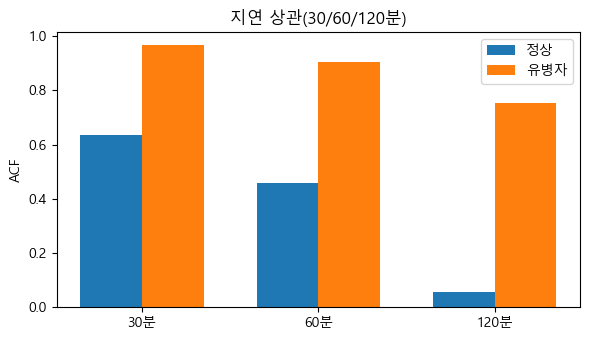

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3.5))
w = 0.35
x = range(len(lags_min))
plt.bar([i - w/2 for i in x], acf_tbl["정상_ACF"], width=w, label="정상")
plt.bar([i + w/2 for i in x], acf_tbl["유병자_ACF"], width=w, label="유병자")
plt.xticks(x, [f"{m}분" for m in lags_min])
plt.ylabel("ACF"); plt.title("지연 상관(30/60/120분)"); plt.legend(); plt.tight_layout(); plt.show()


In [56]:
import numpy as np
import pandas as pd

def baseline_mae(s, horizon_min, ma_windows=(3,12)):
    """s: 5분 간격 시계열, horizon_min: 예측 지평(min), ma_windows: 이동평균 창(스텝 수)
       반환: dict(method->MAE)  (naive, MA-k...)"""
    h = horizon_min // 5
    # 미래 정답
    y_true = s.shift(-h).fillna(method="bfill").fillna(method="ffill")  # ✅ 결측 보정 추가

    out = {}
    # naive: y_hat(t) = y(t)
    y_hat = s.fillna(method="bfill").fillna(method="ffill")             # ✅ 결측 보정 추가
    err = (y_true - y_hat).abs()
    out[f"naive@{horizon_min}m"] = err.mean()

    # 이동평균: 과거 k스텝 평균으로 y_hat(t)
    for k in ma_windows:
        y_hat = s.rolling(k, min_periods=1).mean()                      # rolling 먼저
        y_hat = y_hat.fillna(method="bfill").fillna(method="ffill")     # ✅ 이후 보정
        valid = y_true.notna() & y_hat.notna()
        err = (y_true[valid] - y_hat[valid]).abs()
        out[f"MA{k}@{horizon_min}m"] = err.mean()
    return out

# -------------------------
rows = []
for label, s in [("정상", s_norm), ("유병자", s_dis)]:
    for H in (30, 60, 120):   # ✅ 120분 추가
        res = baseline_mae(s, H, ma_windows=(3,12))  
        row = {"group": label, **{k: round(v,2) for k,v in res.items()}}
        rows.append(row)

mae_tbl = pd.DataFrame(rows)
mae_tbl


,group,naive@30m,MA3@30m,MA12@30m,naive@60m,MA3@60m,MA12@60m,naive@120m,MA3@120m,MA12@120m
0,정상,9.71,8.99,10.12,NaN,NaN,NaN,NaN,NaN,NaN
1,정상,NaN,NaN,NaN,12.02,11.54,12.80,NaN,NaN,NaN
2,정상,NaN,NaN,NaN,NaN,NaN,NaN,16.77,16.38,16.20
3,유병자,3.13,3.49,4.85,NaN,NaN,NaN,NaN,NaN,NaN
4,유병자,NaN,NaN,NaN,5.25,5.55,6.73,NaN,NaN,NaN
5,유병자,NaN,NaN,NaN,NaN,NaN,NaN,8.65,8.87,9.72


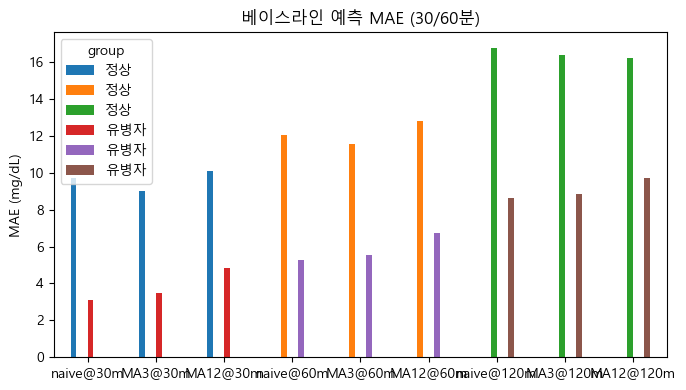

In [57]:
cols = [c for c in mae_tbl.columns if c != "group"]
ax = mae_tbl.set_index("group")[cols].T.plot(kind="bar", figsize=(7,4))
ax.set_ylabel("MAE (mg/dL)"); ax.set_title("베이스라인 예측 MAE (30/60분)")
plt.xticks(rotation=0); plt.tight_layout(); plt.show()


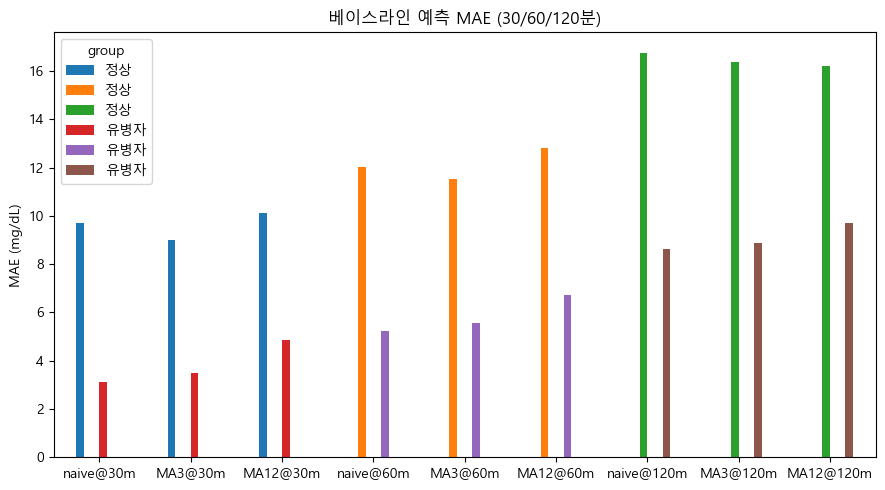

In [58]:
# -----------------------------
# 베이스라인 예측 MAE (30/60/120분)
# -----------------------------
import matplotlib.pyplot as plt

# group 컬럼 빼고 모든 컬럼 사용 (30m, 60m, 120m 전부 포함)
cols = [c for c in mae_tbl.columns if c != "group"]

ax = mae_tbl.set_index("group")[cols].T.plot(kind="bar", figsize=(9,5))
ax.set_ylabel("MAE (mg/dL)")
ax.set_title("베이스라인 예측 MAE (30/60/120분)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


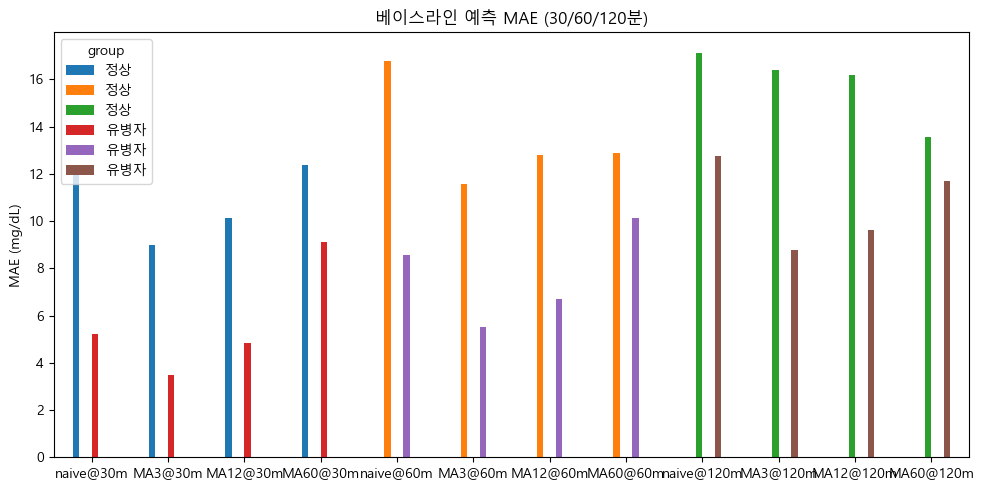

In [52]:
import matplotlib.pyplot as plt

# group 제외한 모든 컬럼 선택 (자동으로 30m, 60m, 120m 다 포함됨)
cols = [c for c in mae_tbl.columns if c != "group"]

# bar plot
ax = mae_tbl.set_index("group")[cols].T.plot(kind="bar", figsize=(10,5))
ax.set_ylabel("MAE (mg/dL)")
ax.set_title("베이스라인 예측 MAE (30/60/120분)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [32]:
from scipy.stats import mannwhitneyu

def abs_errors(s, horizon_min, method="naive", k=None):
    h = horizon_min // 5
    y_true = s.shift(-h)
    if method == "naive":
        y_hat = s
    else:
        y_hat = s.rolling(k, min_periods=k).mean()
    return (y_true - y_hat).abs().dropna()

e_norm = abs_errors(s_norm, 60, method="naive")
e_dis  = abs_errors(s_dis,  60, method="naive")

U, p = mannwhitneyu(e_dis, e_norm, alternative="two-sided")
print(f"naive@60m 절대오차 분포 차이(유병자 vs 정상): p={p:.4f} | "
      f"정상 MAE={e_norm.mean():.2f}, 유병자 MAE={e_dis.mean():.2f}")


naive@60m 절대오차 분포 차이(유병자 vs 정상): p=0.0000 | 정상 MAE=12.03, 유병자 MAE=5.23


In [33]:
cols = [c for c in mae_tbl.columns if c != "group"]
display(mae_tbl.set_index("group")[cols].round(2))


,naive@30m,MA3@30m,MA12@30m,naive@60m,MA3@60m,MA12@60m
group,,,,,,
정상,9.71,8.99,10.12,NaN,NaN,NaN
정상,NaN,NaN,NaN,12.03,11.55,12.81
유병자,3.13,3.49,4.83,NaN,NaN,NaN
유병자,NaN,NaN,NaN,5.23,5.51,6.68


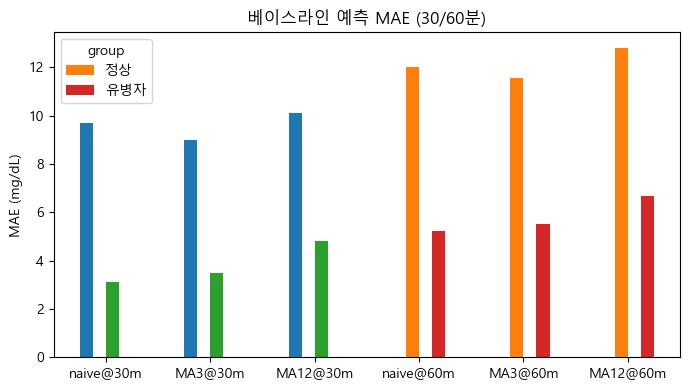

In [34]:
import matplotlib.pyplot as plt

cols = [c for c in mae_tbl.columns if c != "group"]
ax = mae_tbl.set_index("group")[cols].T.plot(kind="bar", figsize=(7,4))
ax.set_ylabel("MAE (mg/dL)")
ax.set_title("베이스라인 예측 MAE (30/60분)")
plt.xticks(rotation=0)
# 범례 중복 제거
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), title="group")
plt.tight_layout(); plt.show()


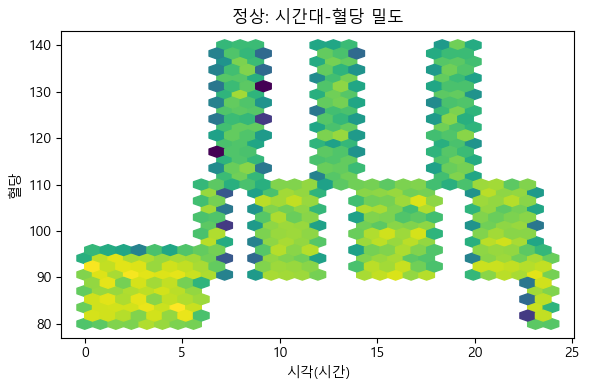

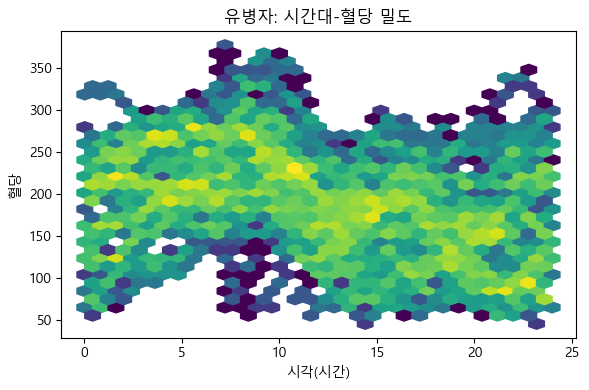

In [35]:
def hour_hexbin(df, title):
    d = df.copy()
    d["hour"] = d["ds"].dt.hour + d["ds"].dt.minute/60
    plt.figure(figsize=(6,4))
    plt.hexbin(d["hour"], d["y"], gridsize=30, bins="log")
    plt.xlabel("시각(시간)"); plt.ylabel("혈당")
    plt.title(title); plt.tight_layout(); plt.show()

hour_hexbin(norm_eq, "정상: 시간대-혈당 밀도")
hour_hexbin(dis_eq,  "유병자: 시간대-혈당 밀도")


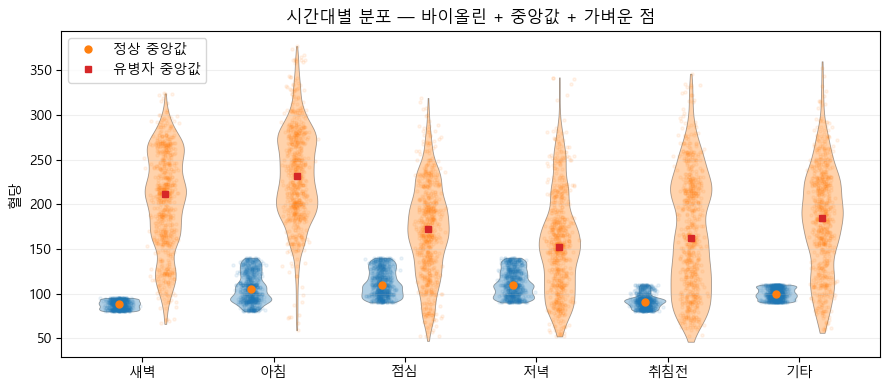

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def add_daypart(d):
    h = d["ds"].dt.hour
    return np.select(
        [h.between(1,4), h.between(5,9), h.between(11,14), h.between(18,21), (h>=22)|(h==0)],
        ["새벽","아침","점심","저녁","취침전"], default="기타"
    )

# 준비: 두 세트 합치고 시간대 라벨링
dn = norm_eq.copy(); dn["group"]="정상";  dn["daypart"] = add_daypart(dn)
dd = dis_eq.copy();  dd["group"]="유병자"; dd["daypart"] = add_daypart(dd)
df = pd.concat([dn, dd], ignore_index=True)

order = ["새벽","아침","점심","저녁","취침전","기타"]
pos   = np.arange(len(order))
width = 0.35
rng   = np.random.default_rng(1)
colors = {"정상":"C0","유병자":"C1"}  # matplotlib 기본 색상 팔레트

fig, ax = plt.subplots(figsize=(9,4))

for i, grp in enumerate(["정상","유병자"]):
    data = [df[(df["group"]==grp) & (df["daypart"]==lab)]["y"].values for lab in order]
    positions = pos + (i-0.5)*width

    # 1) 바이올린(분포 모양)
    v = ax.violinplot(
        data, positions=positions, widths=width*0.9,
        showmeans=False, showmedians=False, showextrema=False
    )
    for b in v["bodies"]:
        b.set_alpha(0.35)
        b.set_facecolor(colors[grp])
        b.set_edgecolor("k")
        b.set_linewidth(0.6)

    # 2) 중앙값 마커
    med = [np.median(a) if len(a)>0 else np.nan for a in data]
    ax.plot(positions, med,
            marker=("o" if grp=="정상" else "s"),
            linestyle="None", markersize=5, label=f"{grp} 중앙값")

    # 3) 가벼운 점(jitter) 오버레이 (샘플링)
    for j, yvals in enumerate(data):
        if len(yvals)==0: continue
        n = min(700, len(yvals))  # 과밀 방지
        idx = rng.choice(len(yvals), n, replace=False)
        x = np.full(n, positions[j]) + rng.normal(0, width*0.12, size=n)
        ax.scatter(x, yvals[idx], s=5, alpha=0.08, color=colors[grp], rasterized=True)

ax.set_xticks(pos)
ax.set_xticklabels(order)
ax.set_ylabel("혈당")
ax.set_title("시간대별 분포 — 바이올린 + 중앙값 + 가벼운 점")
ax.grid(axis="y", alpha=0.2)
ax.legend()
# ax.set_ylim(60, 320)  # 필요하면 Y축 범위 고정
plt.tight_layout(); plt.show()
